In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# Operator learning kernel methods for 1 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [3]:
# may need to Runtime > Restart session if loading for the first time
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import torch
import lightning
import time
from collections import OrderedDict
import os
import warnings
from typing import List

In [4]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"

In [57]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth
LWTHIN = 0.01

## Reference Solution

We will randomly generate $v$ from
$$\exp\left(-\frac{1}{1-r^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$.

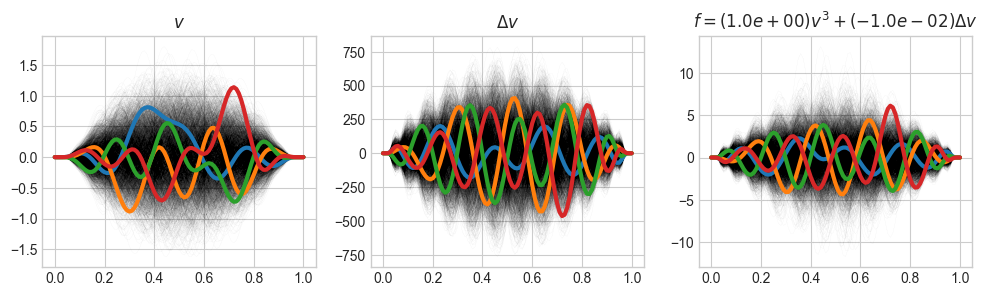

In [58]:
C1 = 1.
C2 = -1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**12
P = 10
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 101
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
coloridxs = torch.arange(4)
ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
ax[0].set_title(r"$v$")
ax[1].set_title(r"$\Delta v$")
ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## PDE setup

In [59]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

## Kernel interpolant setup

In [60]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=1e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(xs,kernel,llbetas,llcs,noise) # kernel interpolant

## Dataset Generation

r from 0 to 4096, l2 relative errors
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
r = 512: [1.0e+00 2.0e+00 1.1e+00 ... 3.9e-06 3.9e-06 3.9e-06]
r = 1024: [1.0e+00 2.0e+00 1.0e+00 ... 3.9e-06 3.9e-06 3.9e-06]
r = 1536: [1.0e+00 3.0e+00 1.8e+00 ... 3.9e-06 3.9e-06 3.9e-06]
r = 2048: [1.0e+00 6.0e-01 1.6e-01 ... 7.9e-06 7.9e-06 7.9e-06]
r = 2560: [1.0e+00 2.1e+00 1.1e+00 ... 8.6e-06 8.6e-06 8.6e-06]
r = 3072: [1.0e+00 4.4e+00 2.7e+00 ... 1.2e-05 1.2e-05 1.2e-05]
r = 3584: [1.0e+00 3.1e+00 1.9e+00 ... 3.6e-06 3.6e-06 3.6e-06]
r = 4096: [1.0e+00 1.4e+00 6.6e-01 ... 6.2e-06 6.2e-06 6.2e-06]


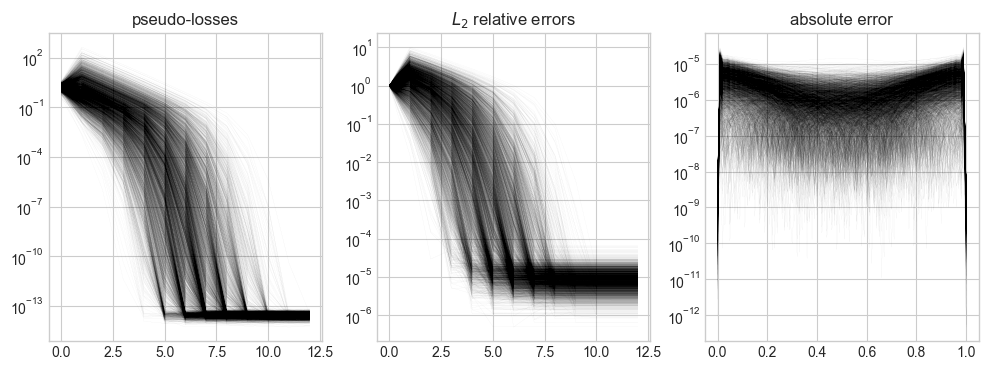

In [61]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "./%s.%s.pt"%("oplearn_elliptic_pde_1d",tag)
    if os.path.exists(fname) and not force_gen:
        data = torch.load(fname)
        vopt = data["vopt"]
        losses_opt = data["losses_opt"]
        l2rerrs = data["l2rerrs"]
    else:
        vopt = torch.empty((R,maxiter+1,ki.length),dtype=float)
        losses_opt = torch.empty((R,maxiter+1),dtype=float)
        vhats = torch.empty((R,maxiter+1,nxticks),dtype=float)
        l2rerrs = torch.empty((R,maxiter+1),dtype=float)
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//8
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,losses_opt[r,:],rerrors_opt,times_opt,vopt[r,:,:] = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                solver = "CHOL",
                verbose = False)
            #coeffs = ki._solve(vopt[r,:,:].T)
            #vhats[r,:,:] = (kvec@coeffs).T
            l2rerrs[r,:] = torch.linalg.norm(vopt[r,:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])
            if (r+1)%verbosity==0:
                with np.printoptions(precision=1,threshold=8):
                    print(l2rerrs[r,:].numpy())
            data = {
                "vopt": vopt,
                "losses_opt": losses_opt,
                "l2rerrs": l2rerrs,}
        torch.save(data,fname)
    return vopt,losses_opt,l2rerrs
vopt,losses_opt,l2rerrs = get_data(maxiter=12,tag="small",force_gen=False)
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
ax[0].set_title("pseudo-losses")
ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
ax[1].set_yscale("log",base=10)
ax[2].set_title("absolute error")
ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
ax[2].set_yscale("log",base=10);

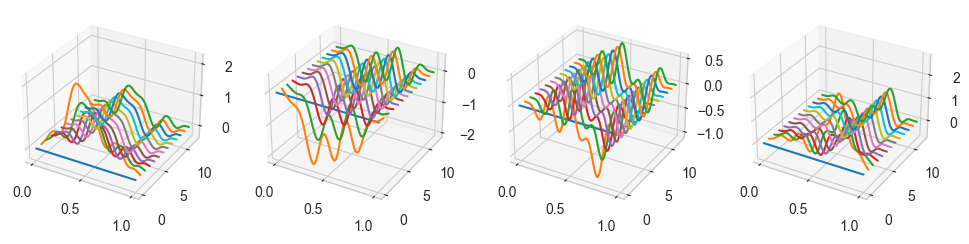

In [76]:
plt_idxs = [0,1,2,3]
ncols = len(plt_idxs)
fig = pyplot.figure(figsize=(12,4))
ax = np.empty(ncols,dtype=object)
_gs = gridspec.GridSpec(1,ncols) 
for i in range(ncols): ax[i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(ncols):
    for k in range(vopt.size(1)):
        ax[i].plot(xticks,k,vopt[plt_idxs[i],k,:nxticks])

## ML modeling

### Train Test Split

In [63]:
uticks.shape,vopt.shape
val_frac = 1/8
tv_idx = torch.arange(R)#torch.from_numpy(dnb2.rng.permutation(R))
_tv_split = R-int(val_frac*R)
tidx = tv_idx[:_tv_split]
vidx = tv_idx[_tv_split:]
print("number train u: %d"%len(tidx))
print("number val   u: %d"%len(vidx))
uticks_train = uticks[tidx]
uticks_val = uticks[vidx]
vopt_train = vopt[tidx]
vopt_val = vopt[vidx]

number train u: 3584
number val   u: 512


### MLP

In [64]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, mlp_layer_nodes:list, activation_function:torch.nn.Module=torch.nn.Tanh(), activate_last_layer:bool=False, scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None):
        super().__init__()
        num_layers = len(mlp_layer_nodes)-1
        self.mlp_layer_nodes = mlp_layer_nodes
        self.output_nodes = self.mlp_layer_nodes[-1]
        layers = []
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",".*Initializing zero-element tensors is a no-op*") # occurs when setting a layer with 0 inputs
            for i in range(num_layers):
                layer = torch.nn.Linear(self.mlp_layer_nodes[i],self.mlp_layer_nodes[i+1])
                if callable(weight_init_scheme):
                    weight_init_scheme(layer.weight)
                layer.bias.data.fill_(0. if self.mlp_layer_nodes[i]>0 else 1.)
                layers.extend([layer,activation_function])
        self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-1]))
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def forward(self, x):
        x = self.mlp_sequential(x).squeeze()
        x = self.output_transform(x)
        return torch.exp(self.logscale)*x+self.bias

In [68]:
class DatasetMLP(torch.utils.data.Dataset):
    def __init__(self, u, v, device="cpu"):
        self.u = u.to(torch.float32)
        self.v = v.to(torch.float32)
        self.i_r,self.i_k = torch.cartesian_prod(torch.arange(u.size(0)),torch.arange(v.size(1)-1)).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik = self.i_r[i],self.i_k[i]
        return self.u[ir],self.v[ir,ik,:],self.v[ir,ik+1,:]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k = self.i_r.to(device),self.i_k.to(device)
        self.u,self.v = self.u.to(device),self.v.to(device)
class MLPLightning(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,v,vnext = batch
        inputs = torch.hstack([u,v])
        vnext_hat = self.mlp(inputs)
        mean_l2rerror = torch.mean(torch.linalg.norm(vnext_hat[:,:nxticks]-vnext[:,:nxticks],dim=1)/torch.linalg.norm(vnext[:,:nxticks],dim=1))
        #loss = mean_l2rerror
        #loss = torch.sqrt(torch.nn.functional.mse_loss(vnext_hat,vnext))
        loss = torch.nn.functional.l1_loss(vnext_hat,vnext)
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(False):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=5e-4,amsgrad=True)
        return optimizer

In [69]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "MLP"
name = "MLP_small"
mlp = MultilayerPerceptron(
    mlp_layer_nodes = [nxticks+ki.length,nxticks+ki.length,nxticks+ki.length,ki.length],
    activation_function = torch.nn.ReLU())
mlp_lightning = MLPLightning(mlp)
mlp.to(DEVICE)
dataset_mlp_train = DatasetMLP(uticks_train,vopt_train,device=DEVICE)
dataset_mlp_val = DatasetMLP(uticks_val,vopt_val,device=DEVICE)
print("number train: %.2e"%len(dataset_mlp_train))
print("number val  : %.2e"%len(dataset_mlp_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_mlp_train = torch.utils.data.DataLoader(dataset_mlp_train,batch_size=2**8,collate_fn=batched_collate_fn,shuffle=True)
dataloader_mlp_val = torch.utils.data.DataLoader(dataset_mlp_val,batch_size=len(dataset_mlp_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 250,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 0.0,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(model=mlp_lightning, train_dataloaders=dataloader_mlp_train, val_dataloaders=dataloader_mlp_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory MLP/MLP_small/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory MLP/MLP_small/csv/checkpoints exists and is not empty.

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 249 K  | train
------------------------------------------------------
249 K     Trainable params
0         Non-trainable params
249 K     Total params
0.996     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


number train: 4.30e+04
number val  : 6.14e+03


Sanity Checking: |    | 0/? [00:00<?, ?it/s]

/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |           | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

,train_loss,val_loss,train_mean_l2rerror,val_mean_l2rerror
1,23.957418,10.119338,9.882114,7.333717
11,5.402390,5.333448,2.726635,2.776467
21,4.106237,4.070129,2.014931,1.988128
31,3.383429,3.330868,1.692144,1.629556
41,2.927792,2.952308,1.542331,1.517551
51,2.571567,2.666548,1.390901,1.396109
61,2.421762,2.400156,1.281994,1.248860
71,2.288010,2.288542,1.251024,1.278957
81,2.151807,2.255168,1.164299,1.205408
91,2.021847,2.048371,1.131796,1.135411


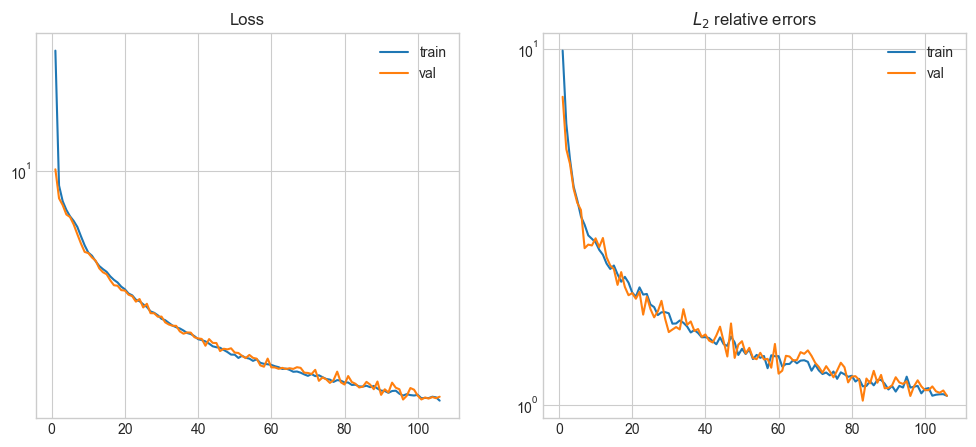

In [70]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_mean_l2rerror"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_mean_l2rerror"].values)]
metrics
metrics = pd.DataFrame({
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    "train_mean_l2rerror": metrics_train["train_mean_l2rerror"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,
})
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["train_loss"],label="train")
ax[0].plot(metrics.index,metrics["val_loss"],label="val")
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(metrics.index,metrics["train_mean_l2rerror"],label="train")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val")
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

### DeepONet

In [26]:
class DeepONet(torch.nn.Module):
    def __init__(self, branches_layers_nodes:list, trunks_layers_nodes:list, branch_activation_function:torch.nn.Module=torch.nn.Tanh(), trunk_activation_function:torch.nn.Module=torch.nn.Tanh(), scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None):
        super().__init__()
        self.branches_layers_nodes,self.trunks_layers_nodes = branches_layers_nodes,trunks_layers_nodes
        self.n_branches,self.n_trunks = len(branches_layers_nodes),len(trunks_layers_nodes)
        self.combining_neurons = trunks_layers_nodes[0][-1]
        self.output_nodes = branches_layers_nodes[0][-1]/self.combining_neurons
        assert self.output_nodes%1==0; self.output_nodes = int(self.output_nodes)
        assert all(branches_layers_nodes[i][-1]==(self.output_nodes*self.combining_neurons) for i in range(self.n_branches)), "Each branch net must have the same number of outputs"
        assert all(trunks_layers_nodes[i][-1]==self.combining_neurons for i in range(self.n_trunks)), "Each trunk net must have the same number of outputs as each branch net"
        self.branch_nets = torch.nn.ModuleList([MultilayerPerceptron(branches_layers_nodes[i],activation_function=branch_activation_function,activate_last_layer=False,scale_last_layer=False,bias_last_layer=False,weight_init_scheme=weight_init_scheme) for i in range(self.n_branches)])
        self.trunk_nets = torch.nn.ModuleList([MultilayerPerceptron(trunks_layers_nodes[i],activation_function=trunk_activation_function,activate_last_layer=True,scale_last_layer=False,bias_last_layer=False,weight_init_scheme=weight_init_scheme) for i in range(self.n_trunks)])
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def _forward_branch_nets(self, x_branches:List[torch.Tensor]):
        assert len(x_branches)==self.n_branches
        y_branches_prod = 1.
        for i,branch_net in enumerate(self.branch_nets):
            y_branches_prod *= branch_net(x_branches[i])
        return y_branches_prod
    def _forward_trunck_nets(self, x_trunks:List[torch.Tensor]):
        assert len(x_trunks)==self.n_trunks
        y_trunks_prod = 1.
        for i,trunk_net in enumerate(self.trunk_nets):
            y_trunks_prod *= trunk_net(x_trunks[i])
        return y_trunks_prod
    def _forward_combine(self, y_branches_prod, y_trunks_prod):
        out = (y_branches_prod.reshape(-1,self.combining_neurons,self.output_nodes)*y_trunks_prod.reshape(-1,self.combining_neurons,1)).sum(1).squeeze()
        out_tf = self.output_transform(out)
        out = torch.exp(self.logscale)*out_tf+self.bias
        return out
    def forward(self, x_branches:List[torch.Tensor], x_trunks:List[torch.Tensor]):
        y_branches_prod = self._forward_branch_nets(x_branches)
        y_trunks_prod = self._forward_trunck_nets(x_trunks)
        out = self._forward_combine(y_branches_prod,y_trunks_prod)
        return out

#### Interior only

In [27]:
class DatasetDeepONeti(torch.utils.data.Dataset):
    def __init__(self, u, v, xs, device="cpu"):
        self.u = u.to(torch.float32)
        self.vi = v[:,:,:nxticks].to(torch.float32)
        # could automatically construct x,beta if given ki
        self.x = xs[0][:,0].to(torch.float32)
        self.i_r,self.i_k,self.i_q = torch.cartesian_prod(torch.arange(self.u.size(0)),torch.arange(self.vi.size(1)-1),torch.arange(self.x.size(0))).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik,iq = self.i_r[i],self.i_k[i],self.i_q[i]
        return self.u[ir],self.vi[ir,ik,:],self.x[iq],self.vi[ir,ik+1,iq]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k,self.i_q = self.i_r.to(device),self.i_k.to(device),self.i_q.to(device)
        self.u,self.vi,self.x = self.u.to(device),self.vi.to(device),self.x.to(device)
class DeepONetLightningi(lightning.LightningModule):
    def __init__(self, don, automatic_optimization=True):
        super().__init__()
        self.don = don
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,vi,x,vinext = batch
        vinext_hat = self.don(x_branches=[u,vi],x_trunks=[x[:,None]])
        loss = torch.nn.functional.l1_loss(vinext_hat,vinext)
        if tag=="val":
            vinext_hat_r,vinext_r = vinext_hat.reshape((-1,nxticks)),vinext.reshape((-1,nxticks))
            mean_l2rerror = torch.mean(torch.linalg.norm(vinext_hat_r-vinext_r,dim=1)/torch.linalg.norm(vinext_r,dim=1))
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        if tag=="val":
            self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(False):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=5e-3,amsgrad=True)
        return optimizer

In [29]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "DeepONet_i"
name = "DeepONet_i_small"
don = DeepONet(
    branches_layers_nodes = [[nxticks,32,32],[nxticks,32,32]],
    trunks_layers_nodes = [[1,32,32,32]],
    branch_activation_function = torch.nn.ReLU(),
    trunk_activation_function = torch.nn.GELU(),
    scale_last_layer = True,
    bias_last_layer = True,
    weight_init_scheme = None,
    )
don_lightning = DeepONetLightningi(don)
don_lightning.to(DEVICE)
dataset_don_train = DatasetDeepONeti(uticks_train,vopt_train,xs,device=DEVICE)
dataset_don_val = DatasetDeepONeti(uticks_val,vopt_val,xs,device=DEVICE)
print("number train: %.1e"%len(dataset_don_train))
print("number val  : %.1e"%len(dataset_don_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_don_train = torch.utils.data.DataLoader(dataset_don_train,batch_size=2**9,collate_fn=batched_collate_fn,shuffle=True)
dataloader_don_val = torch.utils.data.DataLoader(dataset_don_val,batch_size=len(dataset_don_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 10,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 0.,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(model=don_lightning, train_dataloaders=dataloader_don_train, val_dataloaders=dataloader_don_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory DeepONet_i/DeepONet_i_small/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory DeepONet_i/DeepONet_i_small/csv/checkpoints exists and is not empty.

  | Name | Type     | Params | Mode 
------------------------------------------
0 | don  | DeepONet | 10.8 K | train
------------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


number train: 1.2e+05
number val  : 3.9e+04


Sanity Checking: |    | 0/? [00:00<?, ?it/s]

/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |           | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


,train_loss,val_loss,val_mean_l2rerror
1,0.265093,0.264348,0.892344
2,0.254025,0.258450,0.865682
3,0.246920,0.254496,0.859302
4,0.242705,0.248466,0.830815
5,0.236290,0.237706,0.801731
6,0.219306,0.222248,0.776613
7,0.197832,0.203879,0.714665
8,0.173782,0.182164,0.619432
9,0.149518,0.179982,0.596433
10,0.125867,0.164786,0.532042


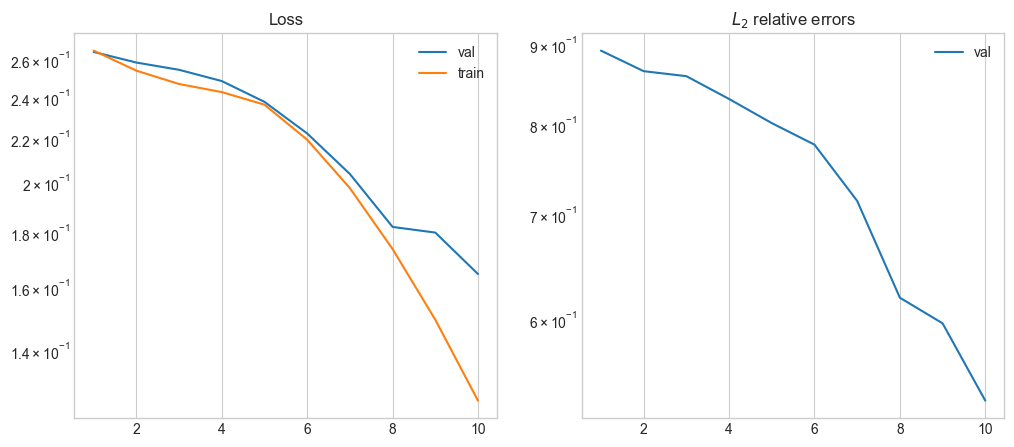

In [30]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics = pd.DataFrame({
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    #"train_mean_l2rerror": metrics_train["train_mean_l2rerror"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,})
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["val_loss"],label="val")
ax[0].plot(metrics.index,metrics["train_loss"],label="train")
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
# ax[1].plot(metrics.index,metrics["train_mean_l2rerror"],label="train")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val")
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

#### Full

In [52]:
class DatasetDeepONet(torch.utils.data.Dataset):
    def __init__(self, u, v, xs, device="cpu"):
        self.u = u.to(torch.float32)
        self.v = v.to(torch.float32)
        # could automatically construct x,beta if given ki
        self.x = torch.hstack([xs[0][:,0],xs[0][:,0],xs[1][:,0]]).to(torch.float32)
        self.beta = torch.hstack([torch.zeros(nxticks,dtype=int),2*torch.ones(nxticks,dtype=int),torch.zeros(2,dtype=int)])
        self.i_r,self.i_k,self.i_q = torch.cartesian_prod(torch.arange(u.size(0)),torch.arange(v.size(1)-1),torch.arange(self.x.size(0))).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik,iq = self.i_r[i],self.i_k[i],self.i_q[i]
        return self.u[ir],self.v[ir,ik,:],self.x[iq],self.beta[iq],self.v[ir,ik+1,iq]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k,self.i_q = self.i_r.to(device),self.i_k.to(device),self.i_q.to(device)
        self.u,self.v,self.x,self.beta = self.u.to(device),self.v.to(device),self.x.to(device),self.beta.to(device)
class DeepONetLightning(lightning.LightningModule):
    def __init__(self, don, automatic_optimization=True):
        super().__init__()
        self.don = don
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,v,x,beta,vnext = batch
        x.requires_grad_()
        vnext_hat = self.don(x_branches=[u,v],x_trunks=[x[:,None]])
        lap_flag = beta==2
        grad_vnext_hat = torch.autograd.grad(vnext_hat,x,grad_outputs=torch.ones_like(x).to(self.device),create_graph=True,retain_graph=True)[0]
        lap_vnext = torch.autograd.grad(grad_vnext_hat,x,grad_outputs=torch.ones_like(x).to(self.device),create_graph=True,retain_graph=True)[0]
        vnext_hat_full = torch.ones_like(vnext_hat)
        vnext_hat_full[~lap_flag] = vnext_hat[~lap_flag]
        vnext_hat_full[lap_flag] = lap_vnext[lap_flag]
        if tag=="val":
            vnext_hat_r,vnext_r = vnext_hat.reshape((-1,ki.length))[:,:nxticks],vnext.reshape((-1,ki.length))[:,:nxticks]
            mean_l2rerror = torch.mean(torch.linalg.norm(vnext_hat_r-vnext_r,dim=1)/torch.linalg.norm(vnext_r,dim=1))
            self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        loss = torch.sqrt(torch.nn.functional.mse_loss(vnext_hat_full,vnext))
        #loss = torch.nn.functional.l1_loss(vnextf_hat,vnext)
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(False):
            return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3,amsgrad=True)
        return optimizer

In [55]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "DeepONet"
name = "DeepONet_small"
don = DeepONet(
    branches_layers_nodes = [[nxticks,128,128],[ki.length,128,128]],
    trunks_layers_nodes = [[1,128,128,128]],
    branch_activation_function = torch.nn.Sigmoid(),
    trunk_activation_function = torch.nn.Tanh(),
    scale_last_layer = True,
    bias_last_layer = True,
    weight_init_scheme = torch.nn.init.kaiming_normal_,
    )
don_lightning = DeepONetLightning(don)
don_lightning.to(DEVICE)
dataset_don_train = DatasetDeepONet(uticks_train,vopt_train,xs,device=DEVICE)
dataset_don_val = DatasetDeepONet(uticks_val,vopt_val,xs,device=DEVICE)
print("number train: %.1e"%len(dataset_don_train))
print("number val  : %.1e"%len(dataset_don_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_don_train = torch.utils.data.DataLoader(dataset_don_train,batch_size=2**12,collate_fn=batched_collate_fn,shuffle=True)
dataloader_don_val = torch.utils.data.DataLoader(dataset_don_val,batch_size=len(dataset_don_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 10,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    num_sanity_val_steps = 0,
    gradient_clip_val = 1.,
    gradient_clip_algorithm = "value",
    #detect_anomaly = True,
  )
trainer.fit(model=don_lightning, train_dataloaders=dataloader_don_train, val_dataloaders=dataloader_don_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory DeepONet/DeepONet_small/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory DeepONet/DeepONet_small/csv/checkpoints exists and is not empty.

  | Name | Type     | Params | Mode 
------------------------------------------
0 | don  | DeepONet | 105 K  | train
------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


number train: 2.4e+05
number val  : 7.8e+04


/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |           | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

Validation: |         | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


,train_loss,val_loss,val_mean_l2rerror
1,122.094360,124.584587,3.310654
2,121.386124,123.465179,3.441644
3,113.466766,105.505089,8.861008
4,91.024338,79.056526,8.942828
5,70.925926,68.609795,6.539623
6,55.563114,53.436649,8.506124
7,44.339600,48.680443,5.152343
8,35.637714,43.800064,7.761721
9,30.241436,42.062046,6.148954
10,26.774940,35.032265,7.095919


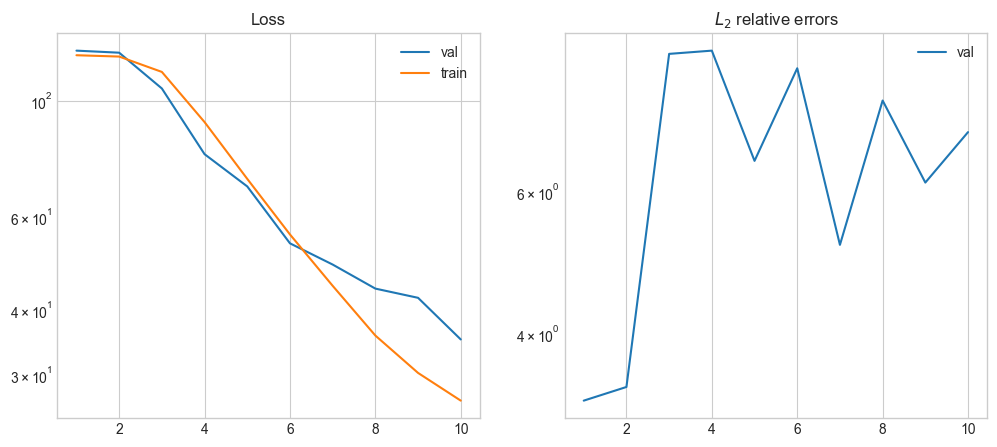

In [56]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics = pd.DataFrame({
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,
})
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["val_loss"],label="val")
ax[0].plot(metrics.index,metrics["train_loss"],label="train")
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val")
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

## Inference